Version 1.0.1

# Check your versions

In [17]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm 

for p in [np, pd, scipy, sklearn, lightgbm]:
    print (p.__name__, p.__version__)

('numpy', '1.13.3')
('pandas', u'0.20.3')
('scipy', '0.18.1')
('sklearn', '0.18.1')
('lightgbm', '2.0.6')


**Important!** There is a huge chance that the assignment will be impossible to pass if the versions of `lighgbm` and `scikit-learn` are wrong. The versions being tested:

    numpy 1.13.1
    pandas 0.20.3
    scipy 0.19.1
    sklearn 0.19.0
    ligthgbm 2.0.6
    

To install an older version of `lighgbm` you may use the following command:
```
pip uninstall lightgbm
pip install lightgbm==2.0.6
```

# Ensembling

In this programming assignment you are asked to implement two ensembling schemes: simple linear mix and stacking.

We will spend several cells to load data and create feature matrix, you can scroll down this part or try to understand what's happening.

In [18]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load data subset

Let's load the data from the hard drive first.

In [61]:
sales = pd.read_csv('./sales_train.csv.gz')
shops = pd.read_csv('./shops.csv')
items = pd.read_csv('./items.csv')
item_cats = pd.read_csv('./item_categories.csv')

In [102]:
test = pd.read_csv('./test.csv.gz')


And use only 3 shops for simplicity.

In [20]:
sales = sales[sales['shop_id'].isin([26, 27, 28])]

In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


# Get a feature matrix

We now need to prepare the features. This part is all implemented for you.

In [64]:

# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
"""
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
"""
grid = []
for block_num in sales['date_block_num'].unique():
    #cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    #cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    #grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
    shop_item_unique_block_num = sales.loc[sales['date_block_num'] == block_num, ['shop_id', 'item_id']].drop_duplicates()
    shop_item_unique_block_num['date_block_num'] = block_num
    grid.append(shop_item_unique_block_num)
grid = pd.concat(grid, axis=0)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

all_data shape before after:

In [63]:
all_data.shape

(10913850, 6)

In [66]:
all_data.shape

(1609124, 6)

### Keeping only necessary ship item pairs

In [22]:
grid = [] 
n = 0
for block_num in sales['date_block_num'].unique():
    #cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    #cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    #grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
    shop_item_unique_block_num = sales.loc[sales['date_block_num'] == block_num, ['shop_id', 'item_id']].drop_duplicates()
    shop_item_unique_block_num['date_block_num'] = block_num
    grid.append(shop_item_unique_block_num)
grid = pd.concat(grid, axis=0)

# Turn the grid into a dataframe
#grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)



In [61]:
grid.shape

(1609124, 3)

In [7]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,2017.0,18.0
1,59,2552,0,0.0,2017.0,0.0
2,59,2554,0,0.0,2017.0,1.0
3,59,2555,0,0.0,2017.0,2.0
4,59,2564,0,0.0,2017.0,5.0


In [22]:
index_cols

['shop_id', 'item_id', 'date_block_num']

After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.

In [67]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

import time
for month_shift in tqdm_notebook(shift_range):
    print month_shift
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)
    time.sleep(.1)
    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
    
    del train_shift
    gc.collect()
    

#del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


1
2
3
4
5
12



To this end, we've created a feature matrix. It is stored in `all_data` variable. Take a look:

In [68]:
all_data.head(5)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,12,3.0,8198.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,12,1.0,8198.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57


In [65]:
all_data.shape

(921400, 25)

In [33]:
all_data.shape

(6425094, 25)

# Train/test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [25]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [29]:
to_drop_cols

['target_item', 'target_shop', 'target', 'date_block_num']

In [26]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

In [47]:
X_train.shape

(6186922, 21)

In [48]:
X_test.shape

(238172, 21)

In [50]:
sales.shape

(2935849, 6)

# Cross-validation

For a given month m, use months 1 through m (excluding m) for training, and month m for validation

In [69]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,12,3.0,8198.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,12,1.0,8198.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57


In [30]:
to_drop_cols

['target_item', 'target_shop', 'target', 'date_block_num']

In [32]:

all_data_dropped = all_data.drop(to_drop_cols, axis=1)

In [34]:
m = 16

In [111]:
all_data.head(40)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id,target_pred
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,5.70
1,54,10296,12,3.0,8198.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38,2.20
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,14.50
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,5.40
4,54,10284,12,1.0,8198.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57,1.00
5,54,10292,12,9.0,8198.0,93.0,8.0,156.0,10055.0,16.0,203.0,7978.0,15.0,279.0,6676.0,38.0,445.0,7827.0,11.0,140.0,7792.0,0.0,0.0,0.0,40,8.00
6,54,10109,12,2.0,8198.0,17.0,1.0,19.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,28.0,7792.0,0.0,0.0,0.0,40,1.60
7,54,10107,12,1.0,8198.0,26.0,2.0,23.0,10055.0,6.0,39.0,7978.0,2.0,48.0,6676.0,6.0,67.0,7827.0,2.0,75.0,7792.0,3.0,32.0,9386.0,37,1.70
8,54,10121,12,1.0,8198.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,9386.0,37,1.10
9,54,10143,12,1.0,8198.0,12.0,1.0,18.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,1.00


In [42]:
X_train = all_data.loc[all_data.date_block_num < m].drop(to_drop_cols, axis=1)
X_val = all_data.loc[all_data.date_block_num == m].drop(to_drop_cols, axis=1)
y_train = all_data.loc[all_data.date_block_num < m, 'target']
y_val = all_data.loc[all_data.date_block_num == m, 'target']

In [43]:
X_train.shape

(34290, 21)

In [44]:
y_train.shape

(34290,)

In [49]:
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)
train_score = r2_score(y_train, y_train_pred)
val_score = r2_score(y_val, y_val_pred)

print("train score: %f, val score: %f" % (train_score, val_score))

train score: 0.615106, val score: 0.209080


In [99]:
#test prediction
X_train_all = all_data.drop(to_drop_cols, axis=1)
y_train_all = all_data['target']

lr.fit(X_train_all, y_train_all)
y_test_pred = lr.predict(X_train_all)

In [100]:
all_data['target_pred'] = y_test_pred 

In [101]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id,target_pred
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,5.7
1,54,10296,12,3.0,8198.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38,2.2
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,14.5
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,5.4
4,54,10284,12,1.0,8198.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57,1.0


In [105]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [107]:
test_all_data_merge = pd.merge(test, all_data, how='left', on=['shop_id', 'item_id'])

In [108]:
test_all_data_merge

,ID,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id,target_pred
0,0,5,5037,20.0,1.0,1355.0,209.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,2.114286
1,0,5,5037,22.0,1.0,1445.0,65.0,0.0,0.0,0.0,1.0,209.0,1355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,2.600000
2,0,5,5037,23.0,2.0,2127.0,233.0,1.0,65.0,1445.0,0.0,0.0,0.0,1.0,209.0,1355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,3.300000
3,0,5,5037,24.0,2.0,1404.0,108.0,2.0,233.0,2127.0,1.0,65.0,1445.0,0.0,0.0,0.0,1.0,209.0,1355.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,2.400000
4,0,5,5037,28.0,1.0,1012.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,108.0,1404.0,2.0,233.0,2127.0,0.0,0.0,0.0,19.0,1.100000
5,0,5,5037,29.0,1.0,954.0,105.0,1.0,87.0,1012.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,108.0,1404.0,0.0,0.0,0.0,19.0,1.200000
6,0,5,5037,30.0,1.0,991.0,54.0,1.0,105.0,954.0,1.0,87.0,1012.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,1.400000
7,0,5,5037,31.0,3.0,1294.0,119.0,1.0,54.0,991.0,1.0,105.0,954.0,1.0,87.0,1012.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,3.100000
8,0,5,5037,32.0,1.0,1092.0,110.0,3.0,119.0,1294.0,1.0,54.0,991.0,1.0,105.0,954.0,1.0,87.0,1012.0,0.0,0.0,0.0,1.0,209.0,1355.0,19.0,1.200000
9,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
from sklearn.linear_model import Ridge


In [94]:
from sklearn.ensemble import RandomForestRegressor
RandomForestRegressor?

In [95]:
lr = RandomForestRegressor()

In [97]:
m_max = np.max(sales.date_block_num)
m_vec = np.arange(m_max/2, m_max + 1)
train_score = np.zeros(m_vec.shape)
val_score = np.zeros(m_vec.shape)

for i, m in enumerate(m_vec):
    X_train = all_data.loc[all_data.date_block_num < m].drop(to_drop_cols, axis=1)
    X_val = all_data.loc[all_data.date_block_num == m].drop(to_drop_cols, axis=1)
    y_train = all_data.loc[all_data.date_block_num < m, 'target']
    y_val = all_data.loc[all_data.date_block_num == m, 'target']
    
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_val_pred = lr.predict(X_val)
    train_score[i] = r2_score(y_train, y_train_pred)
    val_score[i] = r2_score(y_val, y_val_pred)

    print("month %d train scores=%f val-scores=%f" % (m, train_score[i], val_score[i]))
    
print("train scores: %s \n\nval scores: %s" % (str(train_score), str(val_score)))

month 16 train scores=0.945023 val-scores=0.606544
month 17 train scores=0.941341 val-scores=0.615389
month 18 train scores=0.941815 val-scores=0.732516
month 19 train scores=0.953000 val-scores=0.778251
month 20 train scores=0.957739 val-scores=0.359746
month 21 train scores=0.944292 val-scores=0.212004
month 22 train scores=0.937202 val-scores=0.582285
month 23 train scores=0.938358 val-scores=0.665638
month 24 train scores=0.937865 val-scores=0.394765
month 25 train scores=0.941452 val-scores=-1.307837
month 26 train scores=0.923920 val-scores=-0.182267


KeyboardInterrupt: 

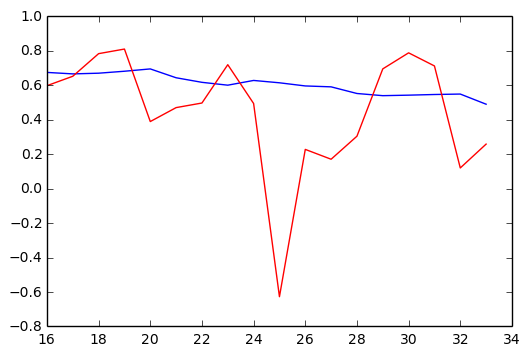

In [91]:
plt.plot(m_vec, train_score)
plt.plot(m_vec, val_score, 'r')


# First level models 

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first. 

### Test meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the last month.

In [68]:
lr = LinearRegression(n_jobs=3)
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))

Test R-squared for linreg is 0.258760


And the we run *LightGBM*.

In [69]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

Test R-squared for LightGBM is 0.296426


Finally, concatenate test predictions to get test meta-features.

In [70]:
X_test_level2 = np.c_[pred_lr, pred_lgb] 

### Train meta-features

**Now it is your turn to write the code**. You need to implement ***scheme f)*** from the reading material. Here, we will use duration **T** equal to month and **M=15**.  

That is, you need to get predictions (meta-features) from *linear regression* and *LightGBM* for months 27, 28, 29, 30, 31, 32. Use the same parameters as in above models.

In [71]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [72]:
dates_train_level2.head()

696174    27
696175    27
696176    27
696177    27
696178    27
Name: date_block_num, dtype: int32

In [73]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

lr_predict = []
lgb_predict = []

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    X_train_level1 = X_train[dates_train < cur_block_num].values
    y_train_level1 = y_train[dates_train < cur_block_num]
    
    X_train_cur = X_train[dates_train == cur_block_num].values
    y_train_cur = y_train[dates_train == cur_block_num]
    
    lr.fit(X_train_level1, y_train_level1)
    lr_predict.append(lr.predict(X_train_cur))

    model = lgb.train(lgb_params, lgb.Dataset(X_train_level1, label=y_train_level1), 100)
    lgb_predict.append(model.predict(X_train_cur))
    
X_train_level2 = np.column_stack([np.concatenate(lr_predict, axis=0), np.concatenate(lgb_predict, axis=0)])

# Sanity check
#assert np.all(np.isclose(X_train_level2.mean(axis=0), [ 1.50148988,  1.38811989]))

27
28
29
30
31
32


In [79]:
X_train_level2.mean(axis=0)

array([ 2.22833413,  2.16345193])

In [24]:
X_train_level2.mean(axis=0)

array([ 0.31640942,  0.29100849])

In [51]:
np.r_[range(10), np.ones((3,))]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,  1.,  1.,  1.])

In [52]:
np.r_[np.ones((3,)), np.ones((3,))]

array([ 1.,  1.,  1.,  1.,  1.,  1.])

In [155]:
np.c_[np.ones((3,)), np.ones((3,))]

array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]])

In [150]:
np.row_stack([np.ones((3,)), np.ones((3,))])

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])

In [151]:
np.column_stack([np.ones((3,)), np.ones((3,))])

array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]])

In [138]:
np.c_[np.ones((3, 1)), np.ones((3, 1))]

array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]])

Remember, the ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig *scatter plot* between the two metafeatures. Plot the scatter plot below. 

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


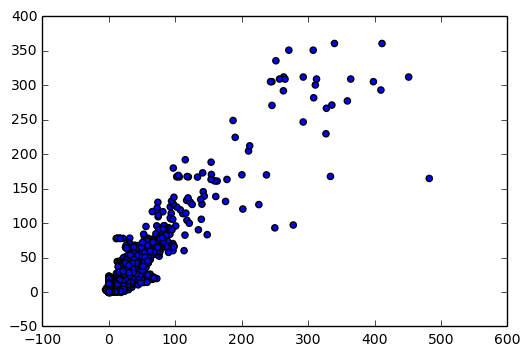

In [36]:
# YOUR CODE GOES HERE
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])

# Ensembling

Now, when the meta-features are created, we can ensemble our first level models.

### Simple convex mix

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. Remember, that you need to use train meta-features (not test) when searching for $\alpha$. 

In [80]:
alphas_to_try = np.linspace(0, 1, 100)

r2_scores = np.zeros(alphas_to_try.shape)
# YOUR CODE GOES HERE
for i, alpha in enumerate(alphas_to_try):
    pred_train_level2 = X_train_level2.dot(np.array([alpha, 1-alpha]).reshape(2, 1)) 
    r2_scores[i] = r2_score(y_train_level2, pred_train_level2)
best_alpha = alphas_to_try[np.argmax(r2_scores)]
r2_train_simple_mix = np.max(r2_scores)

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.202020; Corresponding r2 score on train: 0.271253


Now use the $\alpha$ you've found to compute predictions for the test set 

In [81]:
test_preds = X_test_level2.dot(np.array([best_alpha, 1-best_alpha]).reshape(2, 1))
r2_test_simple_mix = r2_score(y_test, test_preds)

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)

Test R-squared for simple mix is 0.292831


### Stacking

Now, we will try a more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [82]:
lr = LinearRegression()

In [83]:
lr.fit(X_train_level2, y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Compute R-squared on the train and test sets.

In [84]:
train_preds = lr.predict(X_train_level2)
r2_train_stacking = r2_score(y_train_level2, train_preds)

test_preds = lr.predict(X_test_level2)
r2_test_stacking = r2_score(y_test, test_preds)

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Test  R-squared for stacking is %f' % r2_test_stacking)

Train R-squared for stacking is 0.271640
Test  R-squared for stacking is 0.298013


In [30]:
lr.coef_

array([ 0.12059072,  0.9346969 ])

Interesting, that the score turned out to be lower than in previous method. Although the model is very simple (just 3 parameters) and, in fact, mixes predictions linearly, it looks like it managed to overfit. **Examine and compare** train and test scores for the two methods. 

And of course this particular case does not mean simple mix is always better than stacking.

We all done! Submit everything we need to the grader now.

In [61]:
from grader import Grader
grader = Grader()

grader.submit_tag('best_alpha', best_alpha)

grader.submit_tag('r2_train_simple_mix', r2_train_simple_mix)
grader.submit_tag('r2_test_simple_mix',  r2_test_simple_mix)

grader.submit_tag('r2_train_stacking', r2_train_stacking)
grader.submit_tag('r2_test_stacking',  r2_test_stacking)

Current answer for task best_alpha is: 0.7647
Current answer for task r2_train_simple_mix is: 0.62725506463
Current answer for task r2_test_simple_mix is: 0.781177285514
Current answer for task r2_train_stacking is: 0.632175561459
Current answer for task r2_test_stacking is: 0.771297132342


In [62]:
STUDENT_EMAIL = 'amnasri@gmail.com'
STUDENT_TOKEN = 'O3dfSMV7L3TlAHPT'
grader.status()

You want to submit these numbers:
Task best_alpha: 0.7647
Task r2_train_simple_mix: 0.62725506463
Task r2_test_simple_mix: 0.781177285514
Task r2_train_stacking: 0.632175561459
Task r2_test_stacking: 0.771297132342


In [63]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
